In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rand
from sklearn.preprocessing import MinMaxScaler
from collections import deque

In [2]:
import os
os.chdir('C:\\code\\activ')

In [3]:
df_name = 'nov_nine_var.xlsx'

In [4]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

np.set_printoptions(precision=6, suppress=True)

In [5]:
dnn_model = tf.keras.models.load_model('./model/dnn.h5')

In [19]:
# dqn paramater
GAMMA = 0.9
BATCH_SIZE = 1000
ACTION_NUM = 5
SEQUENCE_LENGTH = 12
EPISODE_DONE = 100
EPS_DECAY = 0.99

In [ ]:
action_net0
action_net1
action_net2
action_net3
action_net4

In [8]:
# set action lstm network
for i in range(ACTION_NUM):
        globals()[f'action_net{i}'] = tf.keras.models.load_model('./model/action_net{0}'.format(i))
        print(i)

0
1
2
3
4


In [9]:
df = pd.read_excel('./documents/' + df_name).iloc[:,1::]

scaler = MinMaxScaler()
X = scaler.fit_transform(df.iloc[:,0:21].to_numpy())

starting_state = X[-SEQUENCE_LENGTH::].reshape(1, SEQUENCE_LENGTH, 21)

In [10]:
action_net1(starting_state.reshape(1, 12, 21))

<tf.Tensor: shape=(1, 21), dtype=float32, numpy=
array([[ 0.046262,  1.02393 ,  0.150593,  0.981893,  0.988239,  0.997112,
         0.000832,  0.461403,  0.034366,  0.563065,  0.104653,  0.375023,
         0.154083,  0.266733,  0.054356,  0.181203,  0.954234, -0.013618,
         0.446697,  0.199503,  0.939513]], dtype=float32)>

In [11]:
def set_goal(goal_df_name):
    """ set goal destination
    Args:
        goal_df_name(str): df_name in documents/result/
    Returns:
        goal_state(ndArray, (1, 21)): the state of lowest rate in df
    """
    goal_df = pd.read_excel('./documents/result/' + goal_df_name).iloc[:,1::].to_numpy()
    index = goal_df[:,-1].argmin()

    goal_state = goal_df[:,0:21][index]

    return goal_state

In [12]:
def return_action(s):
    """
    Args:
        s(ndArray, (1, SEQUENCE_LENGTH, 21)): the state
    Returns:
        a(ndArray, (ACTION_NUM, 21)): the action predicted by lstm
    """
    data_num = s.shape[0]
    s = s.reshape(data_num, SEQUENCE_LENGTH, 21)
    action_list = []
    for i in range(ACTION_NUM):
        action = globals()[f'action_net{i}'](s)
        action_list.append(action)
    a = tf.convert_to_tensor(action_list, dtype=tf.float32).reshape(data_num, ACTION_NUM, 21)
    
    return a

In [13]:
def return_state(s, a):
    """ return concatenate s[1::] and a, which mean next state
    Args:
        s(ndArray, (1, SEQUENCE_LENGTH, 21)): the current state
        a(ndArray, (1, 21)): the action on the current state
    Returns:
        ns(ndArray, (1, SEQENCE_LENGTH, 21)): the next state
    """
    ns = np.concatenate((s[0][1::], a), axis=0).reshape(1, SEQUENCE_LENGTH, 21)
    return ns

In [21]:
def return_reward(ns, gs):
    """ evaluate current action
    Args:
        ns(ndArray, (1, SEQUENCE_LENGTH, 21)): the consequence of action in the current state
        gs(ndArray, (1, 21)): the destination
    Returns:
        reward(int): distance to destination + reality of action possible
    """
    gs = scaler.transform(gs)
    dist = np.sqrt(np.sum(np.square(gs - ns[0][-1])))
    loss = dist
    
    return -loss

In [15]:
class DQN_Network(tf.keras.models.Model):
    def __init__(self):
        super(DQN_Network, self).__init__()
        self.input_layer = tf.keras.layers.Dense(128, input_shape=(ACTION_NUM, 21), activation='relu')

        self.hidden_layer = tf.keras.models.Sequential()
        self.hidden_layer.add(tf.keras.layers.Dense(128, activation='relu'))
        self.hidden_layer.add(tf.keras.layers.Dense(128, activation='relu'))

        self.ouput_layer = tf.keras.layers.Dense(1, activation='linear')

    def call(self, s):
        x = return_action(s)
        i = self.input_layer(x)
        h = self.hidden_layer(i)
        o = self.ouput_layer(h)
        return o

In [20]:
class DQN_Agent:
    def __init__(self):
        self.train_model = self.set_model()
        self.target_model = self.set_model()

        self.memory = deque(maxlen=20000)
        self.episode = 1

        self.optim = tf.keras.optimizers.Adam(learning_rate=1e-10)
        self.loss_fn = tf.keras.losses.MeanSquaredError()

    def set_model(self):
        net = DQN_Network()
        net.build(input_shape=(1, SEQUENCE_LENGTH, 21))

        optim = tf.keras.optimizers.Adam(learning_rate=1e-10)
        net.compile(optimizer=optim, loss='mse')
        return net

    def memorize(self, cs, a, a_i, r, ns, d):
        """ append to self.memory
        Args:
            cs(ndArray, (1, SEQUENCE_LENGTH, 21)): the current state
            a(ndArray, (1, 21)): the action on current state
            a_i(int): the index of the action chosen by the agent
            r(int): reward for action in the current state
            ns(ndArray, (1, SEQUENCE_LENGTH, 21)): the next state
            d(boolean): whether to proceed with the episode
        Returns:
            None
        """
        if d:
            self.episode += 1
        
        self.memory.append(
            (
                tf.convert_to_tensor(tf.cast(cs, tf.float32)),
                tf.convert_to_tensor(tf.cast(a, tf.float32)),
                a_i,
                tf.convert_to_tensor(tf.cast(r, tf.float32)),
                tf.convert_to_tensor(tf.cast(ns, tf.float32)),
                d
            )
        )

    def convert_memory_to_input(self):
        batch = rand.sample(self.memory, BATCH_SIZE)
        s, a, a_i, r, ns, d = zip(*batch)

        states = tf.convert_to_tensor(s).reshape(BATCH_SIZE, SEQUENCE_LENGTH, 21)
        actions = tf.convert_to_tensor(a).reshape(BATCH_SIZE, 21)
        action_indexs = tf.convert_to_tensor(a_i)
        rewards = tf.convert_to_tensor(r)
        next_states = tf.convert_to_tensor(ns).reshape(BATCH_SIZE, SEQUENCE_LENGTH, 21)
        dones = tf.convert_to_tensor(d)

        return states, actions, action_indexs, rewards, next_states, dones

    def act(self, state):
        # if self.episode >= 0 and self.episode < 200:
        #     eps_threshold = -(self.episode/1000)+1+(self.episode)*(self.episode-200)/300000
        # else:
        #     eps_threshold = -(self.episode/1000)+1+(self.episode-200)*(self.episode-1000)

        eps_threshold = EPS_DECAY ** self.episode

        a = return_action(state)
        r = self.train_model(state)

        if rand.random() > eps_threshold:
            a_i = np.argmax(r)
        else:
            a_i = rand.randint(0, ACTION_NUM-1)

        return a[0][a_i].reshape(1, 21), a_i, eps_threshold

    def run(self):
        if len(self.memory) < BATCH_SIZE:
            return 1

        states, actions, action_indexs, rewards, next_states, dones = self.convert_memory_to_input()
        loss = self.learn(states, actions, action_indexs, rewards, next_states, dones)
    
        return loss.numpy()
        
    @tf.function
    def learn(self, states, actions, action_indexs, rewards, next_states, dones):
        target_q = self.target_model(next_states)

        q_target = rewards + (1 - dones) * GAMMA * tf.reduce_max(target_q, axis=1, keepdims=True)

        with tf.GradientTape() as tape:
            current_q = self.train_model(states) # 현재 상황에서 할 수 있는 행동들의 q value
            current_q = tf.reduce_sum(current_q[action_indexs], axis=1, keepdims=True) # 실제 한 행동에 대한 q value

            loss = self.loss_fn(current_q, q_target)
        grads = tape.gradient(loss, self.train_model.trainable_weights)
        self.optim.apply_gradients(zip(grads, self.train_model.trainable_weights))

        return loss

In [22]:
agent = DQN_Agent()
rewards_hist = []
st_hist = []

goal_state = set_goal('basic_formula.xlsx').reshape(1, 21)
for e in range(10000):
    counter = [0 for i in range(ACTION_NUM)]
    state = starting_state
    steps = 0
    rewards = 0

    if e % 50 == 0:
        agent.target_model.set_weights(agent.train_model.get_weights())

    while True:
        action, idx, eps = agent.act(state)
        counter[idx] += 1
        next_state = return_state(state, action)
        reward = return_reward(next_state, goal_state)

        if steps == EPISODE_DONE or all(state[0][-1][i] == goal_state[0][i] for i in range(21)):
            done = True
        else:
            done = False

        agent.memorize(state, action, idx, reward, next_state, done)
        loss = agent.run()

        state = next_state
        rewards += reward
        steps += 1

        if steps % 10 == 0:
            print(f'steps: {steps}, reward: {reward}')

        if done:
            print(f'============={e}=============')
            print(round(rewards, 3), round(loss, 3), max(counter), round(eps, 5))
            print("=============================")
            rewards_hist.append(rewards)
            st_hist.append(state)
            break

steps: 10, reward: -1.8894538885112586
steps: 20, reward: -1.8603057360000046
steps: 30, reward: -1.791429627661269
steps: 40, reward: -1.7887223102579373
steps: 50, reward: -1.8369469918867547
steps: 60, reward: -1.833842680638964
steps: 70, reward: -1.8314609136105036
steps: 80, reward: -1.8238000963259973
steps: 90, reward: -1.8047622650893758
steps: 100, reward: -1.8276757433106026
=============0=============
-183.855 1 24 0.99
steps: 10, reward: -1.8512855622890987
steps: 20, reward: -1.7858737821359179
steps: 30, reward: -1.8495713266812093
steps: 40, reward: -1.8206204751011632
steps: 50, reward: -1.874459242271671
steps: 60, reward: -1.8285099411167813
steps: 70, reward: -1.8529636384490908
steps: 80, reward: -1.8901231585821592
steps: 90, reward: -1.8994413378992538
steps: 100, reward: -1.7661412806486152
=============1=============
-186.919 1 27 0.9801
steps: 10, reward: -1.8524590853236418
steps: 20, reward: -1.8953297726305274
steps: 30, reward: -1.8343793713886412
steps: 4

KeyboardInterrupt: 

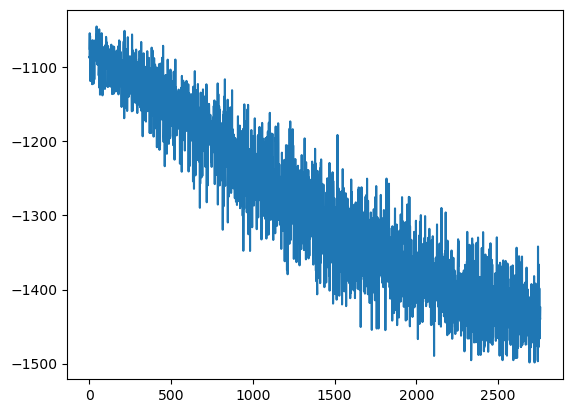

In [ ]:
plt.plot(rewards_hist)